In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

C:\Users\Hassa\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [28]:
data_train_path = r'C:\Face Recognition Dataset\train'
data_test_path = r'C:\Face Recognition Dataset\test'
data_validation_path = r'C:\Face Recognition Dataset\validation'

In [29]:
img_width = 48 
img_height = 48

In [38]:
data_train = tf.keras.utils.image_dataset_from_directory(
data_train_path,
shuffle = True,
image_size = (img_width, img_height),
batch_size = 64,
validation_split = False,
color_mode='grayscale',
labels='inferred',        
)

Found 28709 files belonging to 7 classes.


In [39]:
data_validation = tf.keras.utils.image_dataset_from_directory(
data_validation_path,
shuffle = True,
image_size = (img_width, img_height),
batch_size = 64,
validation_split = False,
color_mode='grayscale',
labels='inferred',     
)

Found 7066 files belonging to 7 classes.


In [40]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
shuffle = True,
image_size = (img_width, img_height),
batch_size = 64,
validation_split = False,
color_mode='grayscale',
labels='inferred', 
)

Found 7178 files belonging to 7 classes.


In [42]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(48,48,1)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))          

model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [50]:
data_train = data_train.repeat()

model_info = model.fit(
    data_train,
    steps_per_epoch=28709//64,
    epochs=50,
    validation_data=data_validation,
    validation_steps=7066//64,
    verbose=1
)

Epoch 1/50
448/448 [==============================] - 88s 194ms/step - loss: 1.1455 - accuracy: 0.5641 - val_loss: 1.0581 - val_accuracy: 0.5993
Epoch 2/50
448/448 [==============================] - 92s 205ms/step - loss: 1.0985 - accuracy: 0.5827 - val_loss: 1.0253 - val_accuracy: 0.6170
Epoch 3/50
448/448 [==============================] - 90s 202ms/step - loss: 1.0625 - accuracy: 0.5940 - val_loss: 0.9865 - val_accuracy: 0.6313
Epoch 4/50
448/448 [==============================] - 93s 208ms/step - loss: 1.0250 - accuracy: 0.6130 - val_loss: 0.9483 - val_accuracy: 0.6516
Epoch 5/50
448/448 [==============================] - 90s 202ms/step - loss: 0.9931 - accuracy: 0.6262 - val_loss: 0.9097 - val_accuracy: 0.6687
Epoch 6/50
448/448 [==============================] - 88s 196ms/step - loss: 0.9508 - accuracy: 0.6403 - val_loss: 0.8679 - val_accuracy: 0.6905
Epoch 7/50
448/448 [==============================] - 88s 197ms/step - loss: 0.9064 - accuracy: 0.6593 - val_loss: 0.8144 - val_ac

In [51]:
model_json = model.to_json()
with open('emotion_model3.json','w') as json_file:
    json_file.write(model_json)

In [52]:
model.save_weights('emotion_model3.h5')

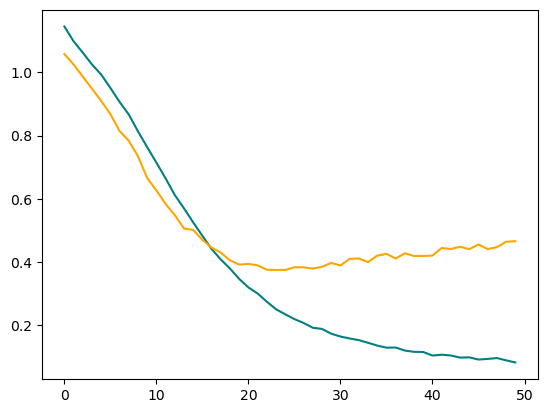

In [53]:
fig = plt.figure()
plt.plot(model_info.history['loss'], color='teal', label='loss')
plt.plot(model_info.history["val_loss"], color='orange', label='val_loss')
fig.suptitle=('Loss')
plt.show()

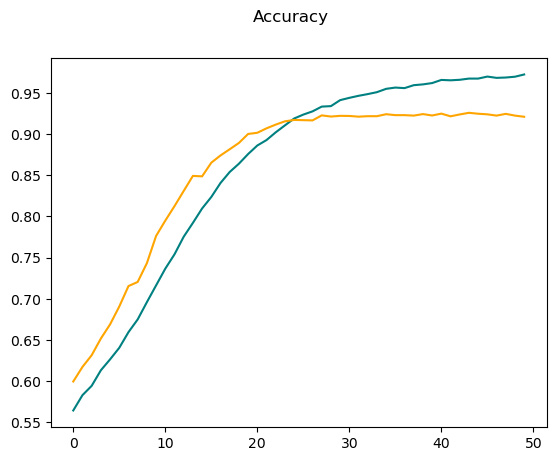

In [54]:
fig = plt.figure()
plt.plot(model_info.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_info.history["val_accuracy"], color='orange', label='val_accuracy')
fig.suptitle('Accuracy')t
plt.show()

In [5]:
json_file=open(r'C:\Users\Hassa\emotion_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r'C:\Users\Hassa\emotion_model.h5')

data_test_path =  r'C:\Face Recognition Dataset\test\sad'

emotion_dic = {0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}
wrong_predictions_count = 0
total_files = 0

for filename in os.listdir(data_test_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        total_files += 1
        image_path = os.path.join(data_test_path, filename)
        image = cv2.imread(image_path)
        

        image = cv2.resize(image, (48, 48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=(0, -1)) 
        
   
        predictions = model.predict(image)
        

        predicted_class = np.argmax(predictions)
        score = tf.nn.softmax(predictions)

        print("Image",filename,"is",emotion_dic[predicted_class],"with accuracy of",np.max(score*100),"\n")
        if predicted_class != 5:  # Assuming class 5 corresponds to 'Sad'
            wrong_predictions_count += 1
            
prediction_accuracy = (total_files - wrong_predictions_count) / total_files * 100
print("Number of wrong predictions:", wrong_predictions_count)
print("Prediction accuracy:", prediction_accuracy, "%")

1/1 [==============================] - 0s 100ms/step
Image PrivateTest_10247676.jpg is Sad with accuracy of 16.860395 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_10455506.jpg is Sad with accuracy of 28.810253 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_10658656.jpg is Surprised with accuracy of 23.622765 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_10702106.jpg is Sad with accuracy of 27.6523 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_10814167.jpg is Sad with accuracy of 20.235323 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_11080550.jpg is Sad with accuracy of 26.145887 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_11127811.jpg is Happy with accuracy of 27.36568 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_11149326.jpg is Angry with accuracy of 25.582233 

1/1 [==============================] - 0

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_30128077.jpg is Fearful with accuracy of 20.742428 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_30137315.jpg is Sad with accuracy of 22.249949 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_3019695.jpg is Neutral with accuracy of 31.176292 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_30347635.jpg is Sad with accuracy of 25.281006 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_30396990.jpg is Sad with accuracy of 28.156805 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_3062720.jpg is Sad with accuracy of 21.259789 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_30726678.jpg is Angry with accuracy of 30.952839 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_31227186.jpg is Angry with accuracy of 20.20908 

1/1 [==============================] - 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_38531368.jpg is Sad with accuracy of 30.362453 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_38749222.jpg is Sad with accuracy of 25.371433 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_38870366.jpg is Sad with accuracy of 30.86482 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_38876900.jpg is Fearful with accuracy of 17.756372 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_39077944.jpg is Happy with accuracy of 25.373777 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_39390601.jpg is Fearful with accuracy of 18.822016 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_39577079.jpg is Sad with accuracy of 19.736738 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_39693209.jpg is Fearful with accuracy of 20.384907 

1/1 [==============================

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_51237975.jpg is Sad with accuracy of 29.408281 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_51679046.jpg is Sad with accuracy of 26.639261 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_51709643.jpg is Fearful with accuracy of 22.507404 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_51713257.jpg is Sad with accuracy of 16.227453 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_51930291.jpg is Happy with accuracy of 26.15946 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_52350274.jpg is Angry with accuracy of 28.036325 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_52351303.jpg is Sad with accuracy of 30.929752 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_52381983.jpg is Sad with accuracy of 29.948156 

1/1 [==============================] - 0s

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_60524578.jpg is Sad with accuracy of 29.465427 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_60567139.jpg is Neutral with accuracy of 23.00211 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_6060400.jpg is Neutral with accuracy of 26.654858 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_60802329.jpg is Fearful with accuracy of 21.156673 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_60808439.jpg is Happy with accuracy of 29.237587 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_60912473.jpg is Sad with accuracy of 25.701178 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_60953134.jpg is Sad with accuracy of 18.365248 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_61085907.jpg is Sad with accuracy of 24.500605 

1/1 [==============================]

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_70796670.jpg is Surprised with accuracy of 22.59051 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_70820178.jpg is Neutral with accuracy of 30.967989 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_70820261.jpg is Neutral with accuracy of 20.13972 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_70891842.jpg is Sad with accuracy of 31.040895 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_709416.jpg is Neutral with accuracy of 19.150106 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_7134876.jpg is Neutral with accuracy of 19.308876 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_71620539.jpg is Sad with accuracy of 26.462263 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_71713293.jpg is Angry with accuracy of 22.496185 

1/1 [========================

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_79875766.jpg is Sad with accuracy of 20.939432 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_79979511.jpg is Angry with accuracy of 21.48958 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_79985549.jpg is Sad with accuracy of 19.91068 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_80214908.jpg is Angry with accuracy of 21.75108 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_80310868.jpg is Happy with accuracy of 20.286999 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_80346458.jpg is Sad with accuracy of 24.359821 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_8044870.jpg is Angry with accuracy of 19.10588 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_80785220.jpg is Sad with accuracy of 22.428143 

1/1 [==============================] - 0s 32m

1/1 [==============================] - 0s 31ms/step
Image PublicTest_13680376.jpg is Sad with accuracy of 28.055716 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_13725132.jpg is Sad with accuracy of 30.595806 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_13830262.jpg is Neutral with accuracy of 29.042906 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_14008187.jpg is Sad with accuracy of 31.092373 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_14406911.jpg is Happy with accuracy of 26.74473 

1/1 [==============================] - 0s 33ms/step
Image PublicTest_14475126.jpg is Neutral with accuracy of 30.725533 

1/1 [==============================] - 0s 34ms/step
Image PublicTest_14489755.jpg is Neutral with accuracy of 24.793978 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_14591455.jpg is Happy with accuracy of 27.58344 

1/1 [==============================] - 0s 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_23286340.jpg is Sad with accuracy of 17.786606 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_23355730.jpg is Sad with accuracy of 24.71798 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_23586952.jpg is Fearful with accuracy of 21.01949 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_23705098.jpg is Neutral with accuracy of 21.718079 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_23782142.jpg is Sad with accuracy of 21.648432 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_23931269.jpg is Neutral with accuracy of 18.67997 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_23975491.jpg is Sad with accuracy of 28.24718 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_24118890.jpg is Sad with accuracy of 23.587671 

1/1 [==============================] - 0s 31ms/s

1/1 [==============================] - 0s 32ms/step
Image PublicTest_31756938.jpg is Neutral with accuracy of 19.633535 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_31832699.jpg is Neutral with accuracy of 17.558372 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_31882260.jpg is Sad with accuracy of 30.364954 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_32322308.jpg is Sad with accuracy of 29.726713 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_32644585.jpg is Neutral with accuracy of 30.996614 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_32730155.jpg is Sad with accuracy of 28.811052 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_32829892.jpg is Happy with accuracy of 21.061607 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_32923630.jpg is Sad with accuracy of 24.698452 

1/1 [==============================] - 0s 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_40599442.jpg is Sad with accuracy of 19.94411 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_40637892.jpg is Angry with accuracy of 18.118435 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_40686855.jpg is Neutral with accuracy of 25.22413 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_40834308.jpg is Sad with accuracy of 21.209066 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_4084269.jpg is Neutral with accuracy of 23.526726 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_40857959.jpg is Sad with accuracy of 27.811176 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_41091993.jpg is Angry with accuracy of 17.836168 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_41127334.jpg is Neutral with accuracy of 23.874443 

1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 29ms/step
Image PublicTest_5084106.jpg is Sad with accuracy of 16.608864 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_50867484.jpg is Sad with accuracy of 30.74796 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_50905235.jpg is Angry with accuracy of 25.357664 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_50927771.jpg is Neutral with accuracy of 18.555721 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_50942295.jpg is Sad with accuracy of 21.39957 

1/1 [==============================] - 0s 36ms/step
Image PublicTest_50982536.jpg is Sad with accuracy of 27.048216 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_51178509.jpg is Neutral with accuracy of 20.0592 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_5122477.jpg is Fearful with accuracy of 19.04087 

1/1 [==============================] - 0s 29ms/st

1/1 [==============================] - 0s 33ms/step
Image PublicTest_59813906.jpg is Sad with accuracy of 22.504032 

1/1 [==============================] - 0s 33ms/step
Image PublicTest_59816922.jpg is Angry with accuracy of 20.29133 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_60061352.jpg is Sad with accuracy of 30.101542 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_60393961.jpg is Sad with accuracy of 25.440983 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_60414831.jpg is Angry with accuracy of 23.517221 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_60435499.jpg is Neutral with accuracy of 22.533339 

1/1 [==============================] - 0s 35ms/step
Image PublicTest_60510521.jpg is Neutral with accuracy of 23.312542 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_60589560.jpg is Angry with accuracy of 28.071447 

1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 24ms/step
Image PublicTest_81022074.jpg is Sad with accuracy of 30.074266 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_81050616.jpg is Sad with accuracy of 25.777933 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_81549573.jpg is Sad with accuracy of 20.602343 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_81609364.jpg is Sad with accuracy of 28.71364 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_81677219.jpg is Surprised with accuracy of 20.699356 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_81975497.jpg is Happy with accuracy of 26.44691 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_81978061.jpg is Angry with accuracy of 20.068996 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_82355488.jpg is Angry with accuracy of 29.779676 

1/1 [==============================] - 0s 24ms

1/1 [==============================] - 0s 32ms/step
Image PublicTest_89937847.jpg is Sad with accuracy of 19.65209 

1/1 [==============================] - 0s 34ms/step
Image PublicTest_90195753.jpg is Neutral with accuracy of 25.985151 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_90237200.jpg is Sad with accuracy of 19.838215 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_90376986.jpg is Angry with accuracy of 18.664064 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_90402522.jpg is Angry with accuracy of 17.983522 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_90423571.jpg is Neutral with accuracy of 27.270237 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_90433770.jpg is Angry with accuracy of 25.076183 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_90439656.jpg is Neutral with accuracy of 19.577845 

1/1 [==============================] - 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_9847816.jpg is Sad with accuracy of 19.606224 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_98681138.jpg is Sad with accuracy of 28.93913 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_98736341.jpg is Sad with accuracy of 28.664505 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_98833450.jpg is Neutral with accuracy of 29.62587 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_99116679.jpg is Happy with accuracy of 31.058979 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_99123958.jpg is Sad with accuracy of 16.130676 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_99393604.jpg is Happy with accuracy of 18.283895 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_99446207.jpg is Neutral with accuracy of 23.464233 

1/1 [==============================] - 0s 25ms/

In [3]:
json_file=open(r'C:\Users\Hassa\emotion_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r'C:\Users\Hassa\emotion_model.h5')

data_test_path =  r'C:\Face Recognition Dataset\test\angry'

emotion_dic = {0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}
wrong_predictions_count = 0
total_files = 0

for filename in os.listdir(data_test_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        total_files += 1
        image_path = os.path.join(data_test_path, filename)
        image = cv2.imread(image_path)
        

        image = cv2.resize(image, (48, 48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=(0, -1)) 
        
   
        predictions = model.predict(image)
        

        predicted_class = np.argmax(predictions)
        score = tf.nn.softmax(predictions)

        print("Image",filename,"is",emotion_dic[predicted_class],"with accuracy of",np.max(score*100),"\n")
        if predicted_class != 0:  # Assuming class 5 corresponds to 'Sad'
            wrong_predictions_count += 1
            
prediction_accuracy = (total_files - wrong_predictions_count) / total_files * 100
print("Number of wrong predictions:", wrong_predictions_count)
print("Prediction accuracy:", prediction_accuracy, "%")

1/1 [==============================] - 0s 81ms/step
Image PrivateTest_10131363.jpg is Happy with accuracy of 22.685863 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_10304478.jpg is Angry with accuracy of 29.346476 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_1054527.jpg is Sad with accuracy of 24.312151 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_10590091.jpg is Angry with accuracy of 24.124933 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_1109992.jpg is Angry with accuracy of 31.145054 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_11296953.jpg is Fearful with accuracy of 30.417427 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_12000629.jpg is Neutral with accuracy of 21.528313 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_12008383.jpg is Angry with accuracy of 31.151947 

1/1 [===========================

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_22793925.jpg is Angry with accuracy of 17.393085 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_22908984.jpg is Fearful with accuracy of 30.7388 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_23120934.jpg is Angry with accuracy of 31.178617 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_23190617.jpg is Angry with accuracy of 26.297369 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_2328297.jpg is Fearful with accuracy of 17.325401 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_23751697.jpg is Angry with accuracy of 21.48294 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_24139016.jpg is Angry with accuracy of 27.846357 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_24550940.jpg is Angry with accuracy of 31.160587 

1/1 [===========================

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_35600895.jpg is Angry with accuracy of 16.3436 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_35694338.jpg is Sad with accuracy of 31.140694 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_35759444.jpg is Angry with accuracy of 31.165684 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_36424712.jpg is Angry with accuracy of 20.46768 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_36922838.jpg is Angry with accuracy of 30.856255 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_36962979.jpg is Fearful with accuracy of 21.84509 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_37179185.jpg is Neutral with accuracy of 20.521885 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_37308382.jpg is Angry with accuracy of 28.622076 

1/1 [=============================

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_46956721.jpg is Neutral with accuracy of 17.380089 

1/1 [==============================] - 0s 37ms/step
Image PrivateTest_47230287.jpg is Neutral with accuracy of 30.70506 

1/1 [==============================] - 0s 34ms/step
Image PrivateTest_47664873.jpg is Angry with accuracy of 21.96278 

1/1 [==============================] - 0s 41ms/step
Image PrivateTest_47881235.jpg is Angry with accuracy of 31.113104 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_48166716.jpg is Angry with accuracy of 24.634195 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_48468437.jpg is Happy with accuracy of 19.706074 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_48563390.jpg is Surprised with accuracy of 25.435867 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_48643898.jpg is Neutral with accuracy of 22.246311 

1/1 [===================

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_60331811.jpg is Sad with accuracy of 17.036299 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_60498147.jpg is Sad with accuracy of 23.534946 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_6097367.jpg is Sad with accuracy of 25.533863 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_60990713.jpg is Angry with accuracy of 30.667606 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_61043821.jpg is Angry with accuracy of 31.05223 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_61094135.jpg is Angry with accuracy of 21.822298 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_61118112.jpg is Angry with accuracy of 24.202982 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_61683353.jpg is Angry with accuracy of 28.104506 

1/1 [==============================] - 0

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_71947816.jpg is Angry with accuracy of 23.095736 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_72495721.jpg is Angry with accuracy of 21.463102 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_73119240.jpg is Angry with accuracy of 29.919893 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_73130508.jpg is Neutral with accuracy of 16.62695 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_731447.jpg is Happy with accuracy of 21.28749 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_73170949.jpg is Angry with accuracy of 17.795265 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_73408654.jpg is Angry with accuracy of 27.260347 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_73419397.jpg is Angry with accuracy of 21.593508 

1/1 [=============================

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_86017870.jpg is Angry with accuracy of 30.569721 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_86408178.jpg is Angry with accuracy of 28.807827 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_86483004.jpg is Angry with accuracy of 23.62552 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_86563903.jpg is Happy with accuracy of 20.37839 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_86650314.jpg is Angry with accuracy of 19.337944 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_87046596.jpg is Angry with accuracy of 30.681509 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_87526826.jpg is Angry with accuracy of 31.033278 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_87767900.jpg is Angry with accuracy of 31.178585 

1/1 [=============================

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_98403294.jpg is Fearful with accuracy of 28.357687 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_9877914.jpg is Angry with accuracy of 28.81173 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_98810281.jpg is Angry with accuracy of 30.82091 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_98865793.jpg is Angry with accuracy of 21.625061 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_99012891.jpg is Sad with accuracy of 19.531849 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_99179335.jpg is Angry with accuracy of 22.715 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_99260703.jpg is Surprised with accuracy of 20.061787 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_99414064.jpg is Neutral with accuracy of 25.492859 

1/1 [===========================

1/1 [==============================] - 0s 26ms/step
Image PublicTest_3627549.jpg is Angry with accuracy of 28.058083 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_3636907.jpg is Neutral with accuracy of 18.966297 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_36373260.jpg is Fearful with accuracy of 18.605534 

1/1 [==============================] - 0s 21ms/step
Image PublicTest_3641062.jpg is Angry with accuracy of 23.42684 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_3641536.jpg is Fearful with accuracy of 29.23435 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_36631182.jpg is Angry with accuracy of 29.804855 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_36659344.jpg is Sad with accuracy of 29.37718 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_36696281.jpg is Happy with accuracy of 19.176197 

1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 24ms/step
Image PublicTest_63705954.jpg is Angry with accuracy of 24.844833 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_63745951.jpg is Angry with accuracy of 26.306677 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_6385751.jpg is Angry with accuracy of 27.510464 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_63906265.jpg is Angry with accuracy of 30.249691 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_64029710.jpg is Angry with accuracy of 24.592829 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_64033113.jpg is Sad with accuracy of 20.568783 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_64680248.jpg is Angry with accuracy of 30.055058 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_64803509.jpg is Sad with accuracy of 22.23652 

1/1 [==============================] - 0s 24ms

1/1 [==============================] - 0s 27ms/step
Image PublicTest_88659438.jpg is Angry with accuracy of 30.895817 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_89139321.jpg is Sad with accuracy of 22.902575 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_89354196.jpg is Angry with accuracy of 24.101633 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_89420020.jpg is Angry with accuracy of 27.531895 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_89421273.jpg is Angry with accuracy of 23.95033 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_89722367.jpg is Angry with accuracy of 27.73788 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_89771874.jpg is Happy with accuracy of 29.836905 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_89957354.jpg is Angry with accuracy of 25.974455 

1/1 [==============================] - 0s 25

In [4]:
json_file=open(r'C:\Users\Hassa\emotion_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r'C:\Users\Hassa\emotion_model.h5')

data_test_path =  r'C:\Face Recognition Dataset\test\disgust'

emotion_dic = {0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}
wrong_predictions_count = 0
total_files = 0

for filename in os.listdir(data_test_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        total_files += 1
        image_path = os.path.join(data_test_path, filename)
        image = cv2.imread(image_path)
        

        image = cv2.resize(image, (48, 48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=(0, -1)) 
        
   
        predictions = model.predict(image)
        

        predicted_class = np.argmax(predictions)
        score = tf.nn.softmax(predictions)

        print("Image",filename,"is",emotion_dic[predicted_class],"with accuracy of",np.max(score*100),"\n")
        if predicted_class != 1:  # Assuming class 5 corresponds to 'Sad'
            wrong_predictions_count += 1
            
prediction_accuracy = (total_files - wrong_predictions_count) / total_files * 100
print("Number of wrong predictions:", wrong_predictions_count)
print("Prediction accuracy:", prediction_accuracy, "%")

1/1 [==============================] - 0s 70ms/step
Image PrivateTest_11895083.jpg is Fearful with accuracy of 18.311893 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_19671520.jpg is Happy with accuracy of 25.548119 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_21629266.jpg is Angry with accuracy of 26.47285 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_22382996.jpg is Disgusted with accuracy of 31.053007 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_26306320.jpg is Disgusted with accuracy of 19.524202 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_29901781.jpg is Disgusted with accuracy of 31.17618 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_30523217.jpg is Angry with accuracy of 24.427055 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_34013087.jpg is Angry with accuracy of 19.881695 

1/1 [===============

1/1 [==============================] - 0s 29ms/step
Image PublicTest_31237465.jpg is Sad with accuracy of 23.456161 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_32023453.jpg is Fearful with accuracy of 29.343214 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_35686619.jpg is Disgusted with accuracy of 31.08243 

1/1 [==============================] - 0s 36ms/step
Image PublicTest_37923555.jpg is Sad with accuracy of 24.663023 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_39191720.jpg is Disgusted with accuracy of 31.178099 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_41393563.jpg is Disgusted with accuracy of 31.16385 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_41633403.jpg is Disgusted with accuracy of 21.77613 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_42217610.jpg is Fearful with accuracy of 18.925108 

1/1 [======================

In [5]:
json_file=open(r'C:\Users\Hassa\emotion_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r'C:\Users\Hassa\emotion_model.h5')

data_test_path =  r'C:\Face Recognition Dataset\test\fear'

emotion_dic = {0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}
wrong_predictions_count = 0
total_files = 0

for filename in os.listdir(data_test_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        total_files += 1
        image_path = os.path.join(data_test_path, filename)
        image = cv2.imread(image_path)
        

        image = cv2.resize(image, (48, 48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=(0, -1)) 
        
   
        predictions = model.predict(image)
        

        predicted_class = np.argmax(predictions)
        score = tf.nn.softmax(predictions)

        print("Image",filename,"is",emotion_dic[predicted_class],"with accuracy of",np.max(score*100),"\n")
        if predicted_class != 2:  # Assuming class 5 corresponds to 'Sad'
            wrong_predictions_count += 1
            
prediction_accuracy = (total_files - wrong_predictions_count) / total_files * 100
print("Number of wrong predictions:", wrong_predictions_count)
print("Prediction accuracy:", prediction_accuracy, "%")

1/1 [==============================] - 0s 71ms/step
Image PrivateTest_10153550.jpg is Sad with accuracy of 24.65461 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_10254684.jpg is Fearful with accuracy of 27.956184 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_10306709.jpg is Fearful with accuracy of 30.749687 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_10555537.jpg is Fearful with accuracy of 21.83856 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_10629254.jpg is Sad with accuracy of 22.686409 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_11014592.jpg is Fearful with accuracy of 30.993334 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_11015881.jpg is Sad with accuracy of 18.136759 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_11251019.jpg is Fearful with accuracy of 24.096676 

1/1 [=========================

Image PrivateTest_19126547.jpg is Fearful with accuracy of 29.384417 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_19235366.jpg is Fearful with accuracy of 25.24483 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_19500320.jpg is Fearful with accuracy of 22.82948 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_19575997.jpg is Fearful with accuracy of 17.501705 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_19618455.jpg is Fearful with accuracy of 24.859146 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_19689419.jpg is Happy with accuracy of 19.6625 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_20037888.jpg is Fearful with accuracy of 18.598282 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_20151184.jpg is Fearful with accuracy of 25.672277 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_2021

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_32467103.jpg is Angry with accuracy of 25.43274 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_32816928.jpg is Fearful with accuracy of 31.126177 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_33051580.jpg is Fearful with accuracy of 30.173594 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_33147800.jpg is Fearful with accuracy of 23.872482 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_33156632.jpg is Fearful with accuracy of 19.760033 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_33204752.jpg is Fearful with accuracy of 30.515566 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_33645189.jpg is Neutral with accuracy of 21.389624 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_33827821.jpg is Fearful with accuracy of 31.03405 

1/1 [===============

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_53302454.jpg is Sad with accuracy of 17.811432 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_53457002.jpg is Fearful with accuracy of 27.670591 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_53584224.jpg is Neutral with accuracy of 19.24319 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_53634197.jpg is Fearful with accuracy of 29.936127 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_53702328.jpg is Fearful with accuracy of 20.629648 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_53707141.jpg is Neutral with accuracy of 22.358713 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_53979011.jpg is Fearful with accuracy of 21.481318 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_54158185.jpg is Sad with accuracy of 25.004202 

1/1 [====================

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_77807334.jpg is Neutral with accuracy of 29.059612 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_77928280.jpg is Fearful with accuracy of 26.608355 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_78083340.jpg is Fearful with accuracy of 27.29524 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_78093204.jpg is Angry with accuracy of 18.780064 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_78097639.jpg is Angry with accuracy of 17.32784 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_7853804.jpg is Fearful with accuracy of 25.987207 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_79285240.jpg is Surprised with accuracy of 30.667473 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_79352177.jpg is Fearful with accuracy of 30.177937 

1/1 [================

1/1 [==============================] - 0s 28ms/step
Image PublicTest_1176231.jpg is Happy with accuracy of 30.393988 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_11794960.jpg is Happy with accuracy of 22.887997 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_11909521.jpg is Surprised with accuracy of 24.07632 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_11980817.jpg is Fearful with accuracy of 30.693623 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_12094155.jpg is Fearful with accuracy of 22.581951 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_12141921.jpg is Fearful with accuracy of 23.743061 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_12212699.jpg is Neutral with accuracy of 18.255507 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_12214722.jpg is Sad with accuracy of 21.575478 

1/1 [===========================

1/1 [==============================] - 0s 24ms/step
Image PublicTest_23140926.jpg is Sad with accuracy of 24.599323 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_23808994.jpg is Surprised with accuracy of 24.531538 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_23835267.jpg is Fearful with accuracy of 30.705696 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_2397242.jpg is Sad with accuracy of 20.191755 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_24421404.jpg is Fearful with accuracy of 31.079124 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_24421678.jpg is Happy with accuracy of 21.83217 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_24478472.jpg is Sad with accuracy of 19.003149 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_24587909.jpg is Sad with accuracy of 20.736998 

1/1 [==============================] - 0s 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_49414561.jpg is Angry with accuracy of 25.540316 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_49583118.jpg is Neutral with accuracy of 21.802458 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_49651304.jpg is Surprised with accuracy of 29.416582 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_49809277.jpg is Sad with accuracy of 28.381453 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_49838260.jpg is Sad with accuracy of 17.442911 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_50055739.jpg is Fearful with accuracy of 29.406796 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_50181562.jpg is Happy with accuracy of 29.80059 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_50361848.jpg is Fearful with accuracy of 21.190857 

1/1 [==============================

1/1 [==============================] - 0s 27ms/step
Image PublicTest_60573222.jpg is Happy with accuracy of 28.148083 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_60697499.jpg is Neutral with accuracy of 23.893742 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_60781650.jpg is Neutral with accuracy of 19.321945 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_60996780.jpg is Fearful with accuracy of 26.830248 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_61207963.jpg is Fearful with accuracy of 30.383295 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_61256129.jpg is Surprised with accuracy of 25.379763 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_61282469.jpg is Angry with accuracy of 29.308113 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_61434389.jpg is Angry with accuracy of 21.324781 

1/1 [=======================

1/1 [==============================] - 0s 24ms/step
Image PublicTest_74024215.jpg is Fearful with accuracy of 21.504215 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_74487623.jpg is Neutral with accuracy of 21.317472 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_74556324.jpg is Fearful with accuracy of 21.067862 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_74704260.jpg is Sad with accuracy of 22.00406 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_74893406.jpg is Fearful with accuracy of 24.019478 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_7503003.jpg is Surprised with accuracy of 21.797619 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_75075294.jpg is Fearful with accuracy of 30.993696 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_75242098.jpg is Sad with accuracy of 21.557917 

1/1 [===========================

1/1 [==============================] - 0s 29ms/step
Image PublicTest_8577582.jpg is Fearful with accuracy of 22.145071 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_858636.jpg is Fearful with accuracy of 17.78125 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_86120099.jpg is Neutral with accuracy of 19.715275 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_86202557.jpg is Fearful with accuracy of 26.71621 

1/1 [==============================] - 0s 33ms/step
Image PublicTest_86240938.jpg is Neutral with accuracy of 17.06225 

1/1 [==============================] - 0s 38ms/step
Image PublicTest_86245007.jpg is Fearful with accuracy of 19.047638 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_86484483.jpg is Fearful with accuracy of 30.567142 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_86498201.jpg is Fearful with accuracy of 30.639717 

1/1 [=========================

1/1 [==============================] - 0s 24ms/step
Image PublicTest_9780746.jpg is Angry with accuracy of 31.114891 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_98053324.jpg is Sad with accuracy of 22.800966 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_98301645.jpg is Surprised with accuracy of 24.89729 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_98414766.jpg is Neutral with accuracy of 20.475021 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_98480835.jpg is Neutral with accuracy of 19.377308 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_98773801.jpg is Fearful with accuracy of 30.70976 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_99053302.jpg is Fearful with accuracy of 31.159369 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_99540987.jpg is Happy with accuracy of 22.155422 

1/1 [============================

In [2]:
json_file=open(r'C:\Users\Hassa\emotion_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r'C:\Users\Hassa\emotion_model.h5')

data_test_path =  r'C:\Face Recognition Dataset\test\happy'

emotion_dic = {0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}
wrong_predictions_count = 0
total_files = 0

for filename in os.listdir(data_test_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        total_files += 1
        image_path = os.path.join(data_test_path, filename)
        image = cv2.imread(image_path)
        

        image = cv2.resize(image, (48, 48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=(0, -1)) 
        
   
        predictions = model.predict(image)
        

        predicted_class = np.argmax(predictions)
        score = tf.nn.softmax(predictions)

        print("Image",filename,"is",emotion_dic[predicted_class],"with accuracy of",np.max(score*100),"\n")
        if predicted_class != 3:  # Assuming class 5 corresponds to 'Sad'
            wrong_predictions_count += 1
            
prediction_accuracy = (total_files - wrong_predictions_count) / total_files * 100
print("Number of wrong predictions:", wrong_predictions_count)
print("Prediction accuracy:", prediction_accuracy, "%")



1/1 [==============================] - 0s 292ms/step
Image PrivateTest_10077120.jpg is Happy with accuracy of 31.16304 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_10470092.jpg is Neutral with accuracy of 18.411203 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_10513598.jpg is Happy with accuracy of 31.122267 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_10516065.jpg is Happy with accuracy of 31.178707 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_10613684.jpg is Happy with accuracy of 31.179098 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_10736786.jpg is Happy with accuracy of 30.241417 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_11070306.jpg is Happy with accuracy of 31.15398 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_11155116.jpg is Sad with accuracy of 28.114527 

1/1 [==========================

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_26389494.jpg is Happy with accuracy of 31.14134 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_26570337.jpg is Happy with accuracy of 31.17794 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_26683191.jpg is Happy with accuracy of 31.179098 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_26861770.jpg is Happy with accuracy of 31.177753 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_26956718.jpg is Happy with accuracy of 31.17909 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_27045032.jpg is Happy with accuracy of 31.060617 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_27068178.jpg is Happy with accuracy of 19.175766 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_27144786.jpg is Happy with accuracy of 31.149155 

1/1 [==============================

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_33336951.jpg is Happy with accuracy of 30.970795 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_33463963.jpg is Happy with accuracy of 31.140774 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_33571817.jpg is Happy with accuracy of 31.176662 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_33607564.jpg is Happy with accuracy of 31.176725 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_3362951.jpg is Neutral with accuracy of 24.705515 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_33854238.jpg is Sad with accuracy of 24.092848 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_33881696.jpg is Neutral with accuracy of 26.826603 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_33883054.jpg is Happy with accuracy of 30.734035 

1/1 [==========================

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_40249114.jpg is Happy with accuracy of 31.17907 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_40251698.jpg is Happy with accuracy of 31.031952 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_40317032.jpg is Happy with accuracy of 23.814423 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_40374609.jpg is Happy with accuracy of 30.938076 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_40479989.jpg is Happy with accuracy of 31.117804 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_40593216.jpg is Happy with accuracy of 31.179089 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_40614798.jpg is Happy with accuracy of 29.283157 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_40679257.jpg is Sad with accuracy of 19.933168 

1/1 [==============================

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_46100411.jpg is Happy with accuracy of 31.175825 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_4628769.jpg is Happy with accuracy of 28.316895 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_46345890.jpg is Happy with accuracy of 31.17909 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_46389051.jpg is Happy with accuracy of 31.178316 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_46477969.jpg is Happy with accuracy of 24.884724 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_46585222.jpg is Happy with accuracy of 28.13108 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_46665621.jpg is Happy with accuracy of 19.07127 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_46775695.jpg is Happy with accuracy of 30.026403 

1/1 [==============================]

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_53148039.jpg is Happy with accuracy of 19.013622 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_53246956.jpg is Happy with accuracy of 31.179098 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_5329013.jpg is Happy with accuracy of 31.17012 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_53333483.jpg is Angry with accuracy of 18.454893 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_53552763.jpg is Happy with accuracy of 31.141975 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_53677858.jpg is Happy with accuracy of 31.177977 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_53681643.jpg is Happy with accuracy of 19.685524 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_53755340.jpg is Happy with accuracy of 31.156382 

1/1 [=============================

1/1 [==============================] - 0s 34ms/step
Image PrivateTest_59417109.jpg is Happy with accuracy of 28.440826 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_59445774.jpg is Happy with accuracy of 31.178942 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_59601460.jpg is Happy with accuracy of 30.841223 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_59812270.jpg is Happy with accuracy of 31.164455 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_59818994.jpg is Happy with accuracy of 26.490572 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_59827709.jpg is Neutral with accuracy of 30.425936 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_59853591.jpg is Disgusted with accuracy of 21.873549 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_59886779.jpg is Surprised with accuracy of 31.10939 

1/1 [==================

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_6539527.jpg is Happy with accuracy of 31.177912 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_65459510.jpg is Happy with accuracy of 21.620106 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_65462321.jpg is Happy with accuracy of 30.670729 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_65504188.jpg is Happy with accuracy of 31.148594 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_65761852.jpg is Happy with accuracy of 31.042286 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_66073047.jpg is Happy with accuracy of 31.17882 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_66103789.jpg is Happy with accuracy of 31.148403 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_66147236.jpg is Happy with accuracy of 31.17907 

1/1 [==============================

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_72875857.jpg is Happy with accuracy of 31.142548 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_72890068.jpg is Happy with accuracy of 30.10852 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_73084625.jpg is Happy with accuracy of 29.355509 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_73152277.jpg is Happy with accuracy of 31.179089 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_73219906.jpg is Happy with accuracy of 30.764814 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_73352286.jpg is Happy with accuracy of 31.06063 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_7339158.jpg is Neutral with accuracy of 27.639902 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_73482952.jpg is Angry with accuracy of 30.505186 

1/1 [============================

1/1 [==============================] - 0s 37ms/step
Image PrivateTest_79550475.jpg is Happy with accuracy of 31.179064 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_79582234.jpg is Happy with accuracy of 30.795135 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_79602374.jpg is Happy with accuracy of 31.13353 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_79763324.jpg is Happy with accuracy of 31.170937 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_79769840.jpg is Happy with accuracy of 31.171434 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_79961256.jpg is Neutral with accuracy of 27.33908 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_8002268.jpg is Happy with accuracy of 29.594309 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_80239348.jpg is Happy with accuracy of 24.426884 

1/1 [============================

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_86387731.jpg is Happy with accuracy of 30.738173 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_8640246.jpg is Happy with accuracy of 21.423592 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_86540003.jpg is Happy with accuracy of 29.34033 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_86728952.jpg is Neutral with accuracy of 17.726158 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_86799610.jpg is Happy with accuracy of 31.179098 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_86947675.jpg is Happy with accuracy of 31.163893 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_86970637.jpg is Angry with accuracy of 31.049374 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_87011890.jpg is Happy with accuracy of 31.179098 

1/1 [===========================

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_92587611.jpg is Happy with accuracy of 31.178846 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_92779835.jpg is Happy with accuracy of 31.034643 

1/1 [==============================] - 0s 21ms/step
Image PrivateTest_92780348.jpg is Happy with accuracy of 31.168865 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_928647.jpg is Happy with accuracy of 31.179056 

1/1 [==============================] - 0s 21ms/step
Image PrivateTest_93033434.jpg is Happy with accuracy of 31.171888 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_93661824.jpg is Happy with accuracy of 31.179003 

1/1 [==============================] - 0s 21ms/step
Image PrivateTest_9367235.jpg is Happy with accuracy of 30.41 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_93786622.jpg is Happy with accuracy of 24.64346 

1/1 [==============================] - 0

1/1 [==============================] - 0s 22ms/step
Image PublicTest_10181609.jpg is Happy with accuracy of 31.158144 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_10245799.jpg is Happy with accuracy of 18.035997 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_10248771.jpg is Happy with accuracy of 31.178566 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_10283102.jpg is Happy with accuracy of 28.54248 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_10303060.jpg is Happy with accuracy of 30.58104 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_10527411.jpg is Happy with accuracy of 31.179094 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_10886374.jpg is Angry with accuracy of 23.671846 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_11060787.jpg is Neutral with accuracy of 25.15341 

1/1 [==============================] - 0s

1/1 [==============================] - 0s 24ms/step
Image PublicTest_17050267.jpg is Happy with accuracy of 31.178766 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_17071643.jpg is Happy with accuracy of 30.03493 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_17081079.jpg is Happy with accuracy of 31.104008 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_1721551.jpg is Happy with accuracy of 31.179014 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_17223895.jpg is Happy with accuracy of 31.127857 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_17291388.jpg is Happy with accuracy of 20.119078 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_17302120.jpg is Happy with accuracy of 27.125607 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_17317594.jpg is Surprised with accuracy of 29.314964 

1/1 [==============================] -

1/1 [==============================] - 0s 23ms/step
Image PublicTest_29869981.jpg is Happy with accuracy of 31.17359 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_30005286.jpg is Neutral with accuracy of 17.424267 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_30017789.jpg is Happy with accuracy of 30.532497 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_30099109.jpg is Happy with accuracy of 31.17834 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_30156147.jpg is Happy with accuracy of 31.171602 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_30185681.jpg is Happy with accuracy of 30.994043 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_30197896.jpg is Happy with accuracy of 24.076992 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_30244131.jpg is Happy with accuracy of 30.991802 

1/1 [==============================] - 0

1/1 [==============================] - 0s 23ms/step
Image PublicTest_43836286.jpg is Happy with accuracy of 21.949717 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_43945833.jpg is Happy with accuracy of 31.11975 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_4395460.jpg is Happy with accuracy of 27.738756 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_4411038.jpg is Happy with accuracy of 30.653784 

1/1 [==============================] - 0s 21ms/step
Image PublicTest_44449594.jpg is Neutral with accuracy of 30.798187 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_44535619.jpg is Happy with accuracy of 31.170141 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_44694203.jpg is Happy with accuracy of 31.179026 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_44770869.jpg is Happy with accuracy of 31.179047 

1/1 [==============================] - 0s

1/1 [==============================] - 0s 22ms/step
Image PublicTest_57427256.jpg is Happy with accuracy of 30.623991 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_57503225.jpg is Happy with accuracy of 31.175179 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_57526339.jpg is Happy with accuracy of 31.166903 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_57534121.jpg is Happy with accuracy of 31.175228 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_57540446.jpg is Happy with accuracy of 29.86908 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_57583021.jpg is Angry with accuracy of 17.688 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_57757862.jpg is Happy with accuracy of 29.860043 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_57762304.jpg is Happy with accuracy of 31.176605 

1/1 [==============================] - 0s 26

1/1 [==============================] - 0s 25ms/step
Image PublicTest_72964768.jpg is Happy with accuracy of 31.179098 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_73176666.jpg is Happy with accuracy of 31.108957 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_73276308.jpg is Happy with accuracy of 30.609768 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_73368258.jpg is Happy with accuracy of 31.12232 

1/1 [==============================] - 0s 21ms/step
Image PublicTest_73443038.jpg is Happy with accuracy of 30.977625 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_73451807.jpg is Happy with accuracy of 31.067648 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_73539778.jpg is Neutral with accuracy of 17.52039 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_73609973.jpg is Happy with accuracy of 26.777256 

1/1 [==============================] - 0

1/1 [==============================] - 0s 24ms/step
Image PublicTest_85314325.jpg is Happy with accuracy of 31.179089 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_85325911.jpg is Happy with accuracy of 31.175745 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_85457087.jpg is Surprised with accuracy of 23.942972 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_8573713.jpg is Happy with accuracy of 30.708614 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_85766163.jpg is Happy with accuracy of 31.17908 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_858686.jpg is Happy with accuracy of 31.178802 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_86236119.jpg is Happy with accuracy of 31.17761 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_86306334.jpg is Happy with accuracy of 31.167585 

1/1 [==============================] - 0s

1/1 [==============================] - 0s 25ms/step
Image PublicTest_98838334.jpg is Happy with accuracy of 28.767555 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_98860460.jpg is Happy with accuracy of 31.179098 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_99092052.jpg is Happy with accuracy of 31.178692 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_99250082.jpg is Happy with accuracy of 19.955244 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_99399200.jpg is Happy with accuracy of 31.179047 

1/1 [==============================] - 0s 33ms/step
Image PublicTest_99531861.jpg is Happy with accuracy of 31.154112 

1/1 [==============================] - 0s 35ms/step
Image PublicTest_99626406.jpg is Happy with accuracy of 30.733377 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_99753173.jpg is Happy with accuracy of 31.176954 

1/1 [==============================] - 0

In [3]:
json_file=open(r'C:\Users\Hassa\emotion_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r'C:\Users\Hassa\emotion_model.h5')

data_test_path =  r'C:\Face Recognition Dataset\test\neutral'

emotion_dic = {0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}
wrong_predictions_count = 0
total_files = 0

for filename in os.listdir(data_test_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        total_files += 1
        image_path = os.path.join(data_test_path, filename)
        image = cv2.imread(image_path)
        

        image = cv2.resize(image, (48, 48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=(0, -1)) 
        
   
        predictions = model.predict(image)
        

        predicted_class = np.argmax(predictions)
        score = tf.nn.softmax(predictions)

        print("Image",filename,"is",emotion_dic[predicted_class],"with accuracy of",np.max(score*100),"\n")
        if predicted_class != 4:  # Assuming class 5 corresponds to 'Sad'
            wrong_predictions_count += 1
            
prediction_accuracy = (total_files - wrong_predictions_count) / total_files * 100
print("Number of wrong predictions:", wrong_predictions_count)
print("Prediction accuracy:", prediction_accuracy, "%")

1/1 [==============================] - 0s 117ms/step
Image PrivateTest_10086748.jpg is Neutral with accuracy of 21.566198 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_10767287.jpg is Sad with accuracy of 30.15731 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_11123843.jpg is Neutral with accuracy of 16.42064 

1/1 [==============================] - 0s 30ms/step
Image PrivateTest_11164800.jpg is Neutral with accuracy of 27.890345 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_11239107.jpg is Neutral with accuracy of 18.63147 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_11262548.jpg is Happy with accuracy of 26.321524 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_1129340.jpg is Neutral with accuracy of 25.748611 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_11724564.jpg is Neutral with accuracy of 31.104326 

1/1 [====================

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_29668485.jpg is Sad with accuracy of 31.0607 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_29684741.jpg is Neutral with accuracy of 30.470472 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_29873933.jpg is Neutral with accuracy of 24.563408 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_29935373.jpg is Neutral with accuracy of 25.766552 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_30366831.jpg is Neutral with accuracy of 31.164047 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_30521631.jpg is Happy with accuracy of 29.428759 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_30720718.jpg is Fearful with accuracy of 22.81535 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_30804097.jpg is Neutral with accuracy of 19.23884 

1/1 [=====================

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_49681286.jpg is Happy with accuracy of 30.683697 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_49758740.jpg is Neutral with accuracy of 20.527304 

1/1 [==============================] - 0s 21ms/step
Image PrivateTest_49891060.jpg is Neutral with accuracy of 30.649248 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_4994356.jpg is Happy with accuracy of 17.867077 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_49985410.jpg is Neutral with accuracy of 29.522442 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_50034169.jpg is Neutral with accuracy of 18.872475 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_50281798.jpg is Sad with accuracy of 21.524357 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_50433951.jpg is Angry with accuracy of 26.341808 

1/1 [======================

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_69389989.jpg is Happy with accuracy of 31.159882 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_69748731.jpg is Happy with accuracy of 28.98443 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_69829588.jpg is Neutral with accuracy of 19.291805 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_698548.jpg is Neutral with accuracy of 30.788418 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_69933453.jpg is Neutral with accuracy of 30.753014 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_70002587.jpg is Neutral with accuracy of 29.86321 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_70019425.jpg is Neutral with accuracy of 21.295551 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_70056004.jpg is Sad with accuracy of 26.066265 

1/1 [=======================

Image PrivateTest_77474785.jpg is Neutral with accuracy of 31.10756 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_77618158.jpg is Neutral with accuracy of 20.623753 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_77696171.jpg is Neutral with accuracy of 19.361328 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_77889273.jpg is Sad with accuracy of 24.61864 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_77995781.jpg is Neutral with accuracy of 30.16983 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_78090705.jpg is Neutral with accuracy of 30.77738 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_78127533.jpg is Neutral with accuracy of 31.1648 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_78373198.jpg is Neutral with accuracy of 30.58622 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_78500449.

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_87759451.jpg is Neutral with accuracy of 31.177532 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_87881437.jpg is Neutral with accuracy of 29.401356 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_88005682.jpg is Neutral with accuracy of 21.803062 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_88221371.jpg is Neutral with accuracy of 24.698988 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_88502368.jpg is Neutral with accuracy of 28.02 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_88731231.jpg is Neutral with accuracy of 30.053822 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_88773298.jpg is Sad with accuracy of 23.72039 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_88784848.jpg is Neutral with accuracy of 28.802145 

1/1 [====================

1/1 [==============================] - 0s 31ms/step
Image PublicTest_1534576.jpg is Neutral with accuracy of 28.932932 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_15463065.jpg is Neutral with accuracy of 21.0751 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_15550175.jpg is Sad with accuracy of 18.545963 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_15581038.jpg is Neutral with accuracy of 26.63748 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_15597876.jpg is Neutral with accuracy of 28.473743 

1/1 [==============================] - 0s 29ms/step
Image PublicTest_15640368.jpg is Neutral with accuracy of 31.175756 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_15723362.jpg is Neutral with accuracy of 17.058603 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_15917705.jpg is Sad with accuracy of 19.41508 

1/1 [==============================] 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_2729310.jpg is Fearful with accuracy of 19.342999 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_27472256.jpg is Neutral with accuracy of 28.512213 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_27506364.jpg is Neutral with accuracy of 21.783838 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_27542435.jpg is Fearful with accuracy of 29.087204 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_27662575.jpg is Fearful with accuracy of 16.15393 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_27885302.jpg is Neutral with accuracy of 22.374006 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_2790951.jpg is Sad with accuracy of 18.856192 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_28123281.jpg is Neutral with accuracy of 21.260565 

1/1 [==========================

1/1 [==============================] - 0s 23ms/step
Image PublicTest_37464818.jpg is Fearful with accuracy of 16.191133 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_3762401.jpg is Neutral with accuracy of 25.08822 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_37663840.jpg is Neutral with accuracy of 30.215841 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_37740054.jpg is Sad with accuracy of 17.392132 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_37742296.jpg is Neutral with accuracy of 22.12281 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_37850371.jpg is Neutral with accuracy of 30.797369 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_38095903.jpg is Happy with accuracy of 31.149757 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_38223740.jpg is Neutral with accuracy of 25.792711 

1/1 [============================

1/1 [==============================] - 0s 24ms/step
Image PublicTest_59596378.jpg is Angry with accuracy of 17.083511 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_59740213.jpg is Neutral with accuracy of 30.701668 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_59837541.jpg is Neutral with accuracy of 31.165447 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_59912520.jpg is Neutral with accuracy of 26.094992 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_6008295.jpg is Happy with accuracy of 17.037975 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_60198319.jpg is Neutral with accuracy of 30.264723 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_60279263.jpg is Neutral with accuracy of 20.639744 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_60499098.jpg is Neutral with accuracy of 28.567474 

1/1 [========================

1/1 [==============================] - 0s 22ms/step
Image PublicTest_70542158.jpg is Happy with accuracy of 20.298708 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_7059610.jpg is Neutral with accuracy of 22.332047 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_70732901.jpg is Neutral with accuracy of 25.590998 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_70884590.jpg is Neutral with accuracy of 26.523165 

1/1 [==============================] - 0s 21ms/step
Image PublicTest_71358939.jpg is Sad with accuracy of 21.605541 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_715636.jpg is Neutral with accuracy of 20.527304 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_71671654.jpg is Angry with accuracy of 30.953941 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_71706318.jpg is Neutral with accuracy of 29.396507 

1/1 [==============================

1/1 [==============================] - 0s 26ms/step
Image PublicTest_79793968.jpg is Neutral with accuracy of 30.796564 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_79833395.jpg is Angry with accuracy of 27.654474 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_79955666.jpg is Neutral with accuracy of 31.175003 

1/1 [==============================] - 0s 21ms/step
Image PublicTest_80029307.jpg is Fearful with accuracy of 17.036783 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_80241027.jpg is Neutral with accuracy of 20.487768 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_80317721.jpg is Neutral with accuracy of 23.13777 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_80584959.jpg is Neutral with accuracy of 25.926262 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_80701941.jpg is Neutral with accuracy of 23.464388 

1/1 [======================

1/1 [==============================] - 0s 26ms/step
Image PublicTest_89519100.jpg is Neutral with accuracy of 25.820065 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_89665046.jpg is Neutral with accuracy of 29.444828 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_89717306.jpg is Neutral with accuracy of 27.677368 

1/1 [==============================] - 0s 30ms/step
Image PublicTest_89904184.jpg is Fearful with accuracy of 19.31494 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_90324891.jpg is Neutral with accuracy of 27.243414 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_90382483.jpg is Surprised with accuracy of 21.578848 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_90494085.jpg is Neutral with accuracy of 26.76867 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_9076186.jpg is Neutral with accuracy of 23.217314 

1/1 [====================

1/1 [==============================] - 0s 23ms/step
Image PublicTest_97469237.jpg is Happy with accuracy of 26.28302 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_9748046.jpg is Neutral with accuracy of 30.284956 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_97525707.jpg is Fearful with accuracy of 21.860746 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_97844767.jpg is Angry with accuracy of 24.76232 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_97855765.jpg is Neutral with accuracy of 23.900764 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_98138554.jpg is Neutral with accuracy of 28.531378 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_98333211.jpg is Neutral with accuracy of 17.623955 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_98470790.jpg is Neutral with accuracy of 27.241993 

1/1 [==========================

In [4]:
json_file=open(r'C:\Users\Hassa\emotion_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r'C:\Users\Hassa\emotion_model.h5')

data_test_path =  r'C:\Face Recognition Dataset\test\surprise'

emotion_dic = {0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}
wrong_predictions_count = 0
total_files = 0

for filename in os.listdir(data_test_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        total_files += 1
        image_path = os.path.join(data_test_path, filename)
        image = cv2.imread(image_path)
        

        image = cv2.resize(image, (48, 48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=(0, -1)) 
        
   
        predictions = model.predict(image)
        

        predicted_class = np.argmax(predictions)
        score = tf.nn.softmax(predictions)

        print("Image",filename,"is",emotion_dic[predicted_class],"with accuracy of",np.max(score*100),"\n")
        if predicted_class != 6:  # Assuming class 5 corresponds to 'Sad'
            wrong_predictions_count += 1
            
prediction_accuracy = (total_files - wrong_predictions_count) / total_files * 100
print("Number of wrong predictions:", wrong_predictions_count)
print("Prediction accuracy:", prediction_accuracy, "%")

1/1 [==============================] - 0s 96ms/step
Image PrivateTest_10072988.jpg is Surprised with accuracy of 30.172014 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_10089743.jpg is Fearful with accuracy of 28.509348 

1/1 [==============================] - 0s 31ms/step
Image PrivateTest_104142.jpg is Surprised with accuracy of 28.954878 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_10427382.jpg is Fearful with accuracy of 19.779877 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_10712253.jpg is Happy with accuracy of 28.957256 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_1076980.jpg is Surprised with accuracy of 28.295639 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_10775220.jpg is Surprised with accuracy of 30.473488 

1/1 [==============================] - 0s 33ms/step
Image PrivateTest_10782186.jpg is Surprised with accuracy of 21.687681 

1/1 [======

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_36377429.jpg is Surprised with accuracy of 30.39156 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_36386071.jpg is Surprised with accuracy of 19.282393 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_36889392.jpg is Surprised with accuracy of 27.906263 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_37239771.jpg is Sad with accuracy of 21.965109 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_37638961.jpg is Surprised with accuracy of 31.098076 

1/1 [==============================] - 0s 26ms/step
Image PrivateTest_37692447.jpg is Surprised with accuracy of 29.800373 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_37963456.jpg is Fearful with accuracy of 22.321411 

1/1 [==============================] - 0s 27ms/step
Image PrivateTest_38343743.jpg is Surprised with accuracy of 28.507896 

1/1 [====

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_6512456.jpg is Surprised with accuracy of 31.175634 

1/1 [==============================] - 0s 28ms/step
Image PrivateTest_6587334.jpg is Surprised with accuracy of 23.320154 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_66131494.jpg is Surprised with accuracy of 19.759161 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_66164599.jpg is Surprised with accuracy of 31.17744 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_66300077.jpg is Surprised with accuracy of 31.178892 

1/1 [==============================] - 0s 23ms/step
Image PrivateTest_66332069.jpg is Surprised with accuracy of 21.558334 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_66702303.jpg is Angry with accuracy of 18.262344 

1/1 [==============================] - 0s 25ms/step
Image PrivateTest_66788337.jpg is Surprised with accuracy of 30.589247 

1/1 [==

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_78614220.jpg is Surprised with accuracy of 30.31212 

1/1 [==============================] - 0s 22ms/step
Image PrivateTest_78713133.jpg is Surprised with accuracy of 31.178993 

1/1 [==============================] - 0s 24ms/step
Image PrivateTest_79429682.jpg is Surprised with accuracy of 31.114717 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_79494187.jpg is Surprised with accuracy of 31.064856 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_79872412.jpg is Surprised with accuracy of 31.176147 

1/1 [==============================] - 0s 32ms/step
Image PrivateTest_80135557.jpg is Surprised with accuracy of 31.080341 

1/1 [==============================] - 0s 29ms/step
Image PrivateTest_80382718.jpg is Surprised with accuracy of 31.140512 

1/1 [==============================] - 0s 35ms/step
Image PrivateTest_80572685.jpg is Surprised with accuracy of 26.102394 

1

Image PublicTest_19807053.jpg is Surprised with accuracy of 31.144396 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_20065771.jpg is Surprised with accuracy of 31.179094 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_20242544.jpg is Surprised with accuracy of 26.576921 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_20248242.jpg is Surprised with accuracy of 27.570673 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_20530760.jpg is Surprised with accuracy of 31.164377 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_20531357.jpg is Surprised with accuracy of 31.16674 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_20677546.jpg is Surprised with accuracy of 31.033405 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_20980168.jpg is Surprised with accuracy of 31.126366 

1/1 [==============================] - 0s 23ms/step
Image Pub

1/1 [==============================] - 0s 23ms/step
Image PublicTest_47965694.jpg is Surprised with accuracy of 31.127024 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_4819015.jpg is Surprised with accuracy of 31.17127 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_48415985.jpg is Surprised with accuracy of 31.133884 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_48874576.jpg is Surprised with accuracy of 31.177586 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_48907173.jpg is Surprised with accuracy of 31.131851 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_48988865.jpg is Fearful with accuracy of 20.090014 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_48991844.jpg is Surprised with accuracy of 30.704617 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_49049109.jpg is Surprised with accuracy of 28.692398 

1/1 [=======

1/1 [==============================] - 0s 24ms/step
Image PublicTest_61779535.jpg is Surprised with accuracy of 30.95867 

1/1 [==============================] - 0s 22ms/step
Image PublicTest_62072018.jpg is Surprised with accuracy of 31.001436 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_62145473.jpg is Neutral with accuracy of 22.396564 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_62174534.jpg is Surprised with accuracy of 31.016901 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_62222978.jpg is Surprised with accuracy of 31.174072 

1/1 [==============================] - 0s 23ms/step
Image PublicTest_62398284.jpg is Surprised with accuracy of 28.97626 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_62963706.jpg is Surprised with accuracy of 19.912315 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_63069551.jpg is Surprised with accuracy of 31.091324 

1/1 [=======

1/1 [==============================] - 0s 25ms/step
Image PublicTest_75062.jpg is Fearful with accuracy of 21.231756 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_75437950.jpg is Surprised with accuracy of 31.178877 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_75474602.jpg is Fearful with accuracy of 27.97708 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_7556977.jpg is Surprised with accuracy of 31.177721 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_7569276.jpg is Happy with accuracy of 30.58737 

1/1 [==============================] - 0s 33ms/step
Image PublicTest_75752209.jpg is Happy with accuracy of 22.727674 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_76349096.jpg is Surprised with accuracy of 26.16868 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_76841432.jpg is Surprised with accuracy of 28.19777 

1/1 [========================

1/1 [==============================] - 0s 26ms/step
Image PublicTest_91929864.jpg is Surprised with accuracy of 31.171057 

1/1 [==============================] - 0s 27ms/step
Image PublicTest_92163287.jpg is Surprised with accuracy of 29.855373 

1/1 [==============================] - 0s 32ms/step
Image PublicTest_92242142.jpg is Surprised with accuracy of 26.870962 

1/1 [==============================] - 0s 31ms/step
Image PublicTest_92484279.jpg is Surprised with accuracy of 30.004019 

1/1 [==============================] - 0s 25ms/step
Image PublicTest_93462303.jpg is Surprised with accuracy of 29.705372 

1/1 [==============================] - 0s 26ms/step
Image PublicTest_93480805.jpg is Happy with accuracy of 26.141062 

1/1 [==============================] - 0s 28ms/step
Image PublicTest_93768797.jpg is Surprised with accuracy of 31.172916 

1/1 [==============================] - 0s 24ms/step
Image PublicTest_93901885.jpg is Surprised with accuracy of 31.178635 

1/1 [=======

In [1]:
total=(76.65+62.53+84.78+39.84+50.45+53.75+44.02)/7
print('Total accuracy=',total)

Total accuracy= 58.86
